In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder

In [3]:
import seaborn as sns

### Loading  & cleaning results data

In [4]:
wmt19_results = pd.read_csv('./evaluate/all_wmt19_results_091620.csv')
wmt19_results.method = wmt19_results.method.str.replace('baseline', 'sentencepiece')

In [5]:
segmentation_methods = set(wmt19_results.method.unique()).union({'morsel'})

In [6]:
segmentation_methods

{'lmvr-tuned', 'morsel', 'sentencepiece', 'subword-nmt'}

In [7]:
flores_full = pd.read_csv('./evaluate/all_results_091320.csv')
flores_full.method = flores_full.method.str.replace('baseline-fp16', 'sentencepiece')

In [8]:
flores_results = flores_full[flores_full.method.isin(segmentation_methods)].copy()

In [9]:
combined_results = pd.concat([flores_results, wmt19_results], ignore_index=True).copy()

In [10]:
combined_results['chrf3'] = 100*combined_results.chrf3
# combined_results['bleu'] = 0.01*combined_results.bleu

### Exploratory analysis with plots

#### Overall BLEU

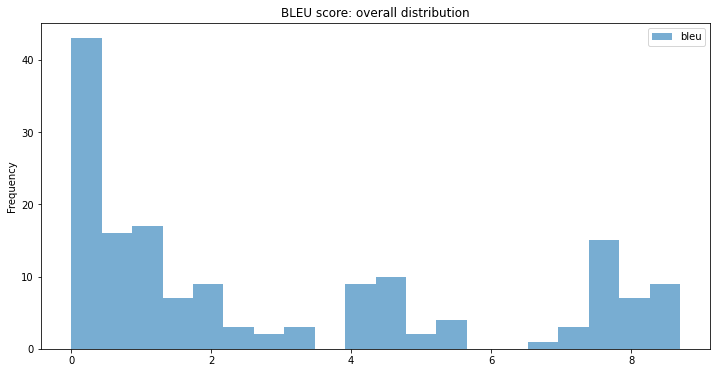

In [11]:
t = 'BLEU score: overall distribution'
combined_results\
    .bleu.plot(kind='hist', title=t,
               alpha=0.6, figsize=(12, 6),
               bins=20, legend=True)

Definitely seems like a multimodal distribution, with possible zero-inflation.

#### Overall CHRF3

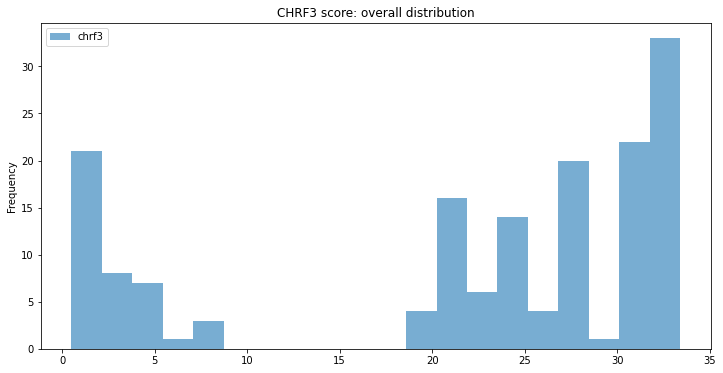

In [12]:
t = 'CHRF3 score: overall distribution'
combined_results\
    .chrf3.plot(kind='hist', title=t,
               alpha=0.6, figsize=(12, 6),
               bins=20, legend=True)

#### BLEU vs CHRF3

Text(0.5, 1.0, 'BLEU vs. CHRF3')

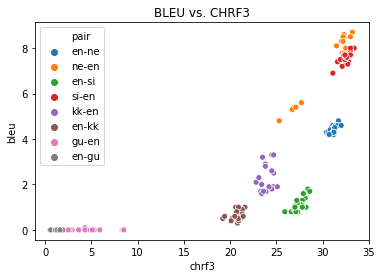

In [13]:
ax = sns.scatterplot(x=combined_results.chrf3, 
                     y=combined_results.bleu, 
                     hue=combined_results.pair)
plt.title("BLEU vs. CHRF3")

pair
en-gu    AxesSubplot(0.125,0.125;0.775x0.755)
en-kk    AxesSubplot(0.125,0.125;0.775x0.755)
en-ne    AxesSubplot(0.125,0.125;0.775x0.755)
en-si    AxesSubplot(0.125,0.125;0.775x0.755)
gu-en    AxesSubplot(0.125,0.125;0.775x0.755)
kk-en    AxesSubplot(0.125,0.125;0.775x0.755)
ne-en    AxesSubplot(0.125,0.125;0.775x0.755)
si-en    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

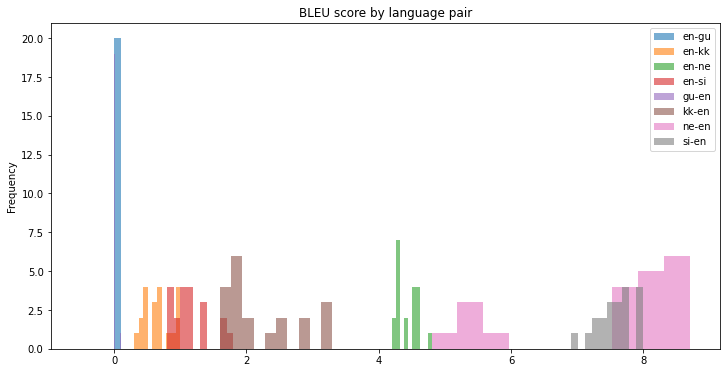

In [14]:
t = 'BLEU score by language pair'
combined_results\
    .groupby(['pair'])\
    .bleu.plot(kind='hist', title=t, stacked=True,
               alpha=0.6, figsize=(12, 6),
               legend=True)

pair
en-gu    AxesSubplot(0.125,0.125;0.775x0.755)
en-kk    AxesSubplot(0.125,0.125;0.775x0.755)
en-ne    AxesSubplot(0.125,0.125;0.775x0.755)
en-si    AxesSubplot(0.125,0.125;0.775x0.755)
gu-en    AxesSubplot(0.125,0.125;0.775x0.755)
kk-en    AxesSubplot(0.125,0.125;0.775x0.755)
ne-en    AxesSubplot(0.125,0.125;0.775x0.755)
si-en    AxesSubplot(0.125,0.125;0.775x0.755)
Name: chrf3, dtype: object

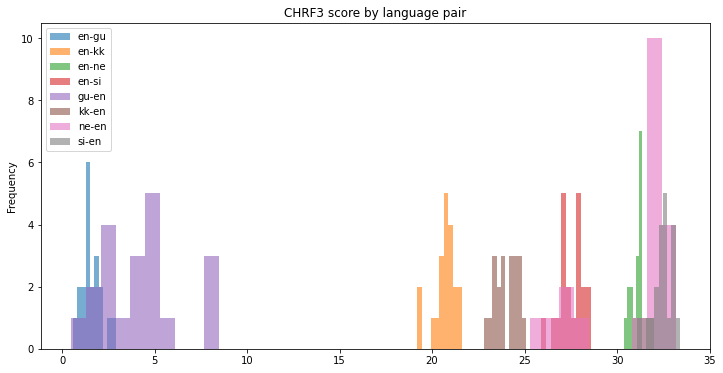

In [15]:
t = 'CHRF3 score by language pair'
combined_results\
    .groupby(['pair'])\
    .chrf3.plot(kind='hist', title=t, stacked=True,
               alpha=0.6, figsize=(12, 6),
               legend=True)

### How do things generally vary by segmentation method?

method
lmvr-tuned       AxesSubplot(0.125,0.125;0.775x0.755)
morsel           AxesSubplot(0.125,0.125;0.775x0.755)
sentencepiece    AxesSubplot(0.125,0.125;0.775x0.755)
subword-nmt      AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

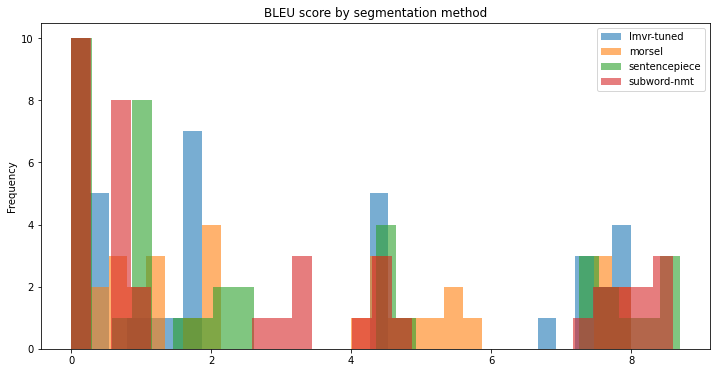

In [16]:
t = 'BLEU score by segmentation method'
combined_results\
    .groupby(['method'])\
    .bleu.plot(kind='hist', title=t, stacked=True,
               alpha=0.6, figsize=(12, 6),
               bins=30, legend=True)

method
lmvr-tuned       AxesSubplot(0.125,0.125;0.775x0.755)
morsel           AxesSubplot(0.125,0.125;0.775x0.755)
sentencepiece    AxesSubplot(0.125,0.125;0.775x0.755)
subword-nmt      AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

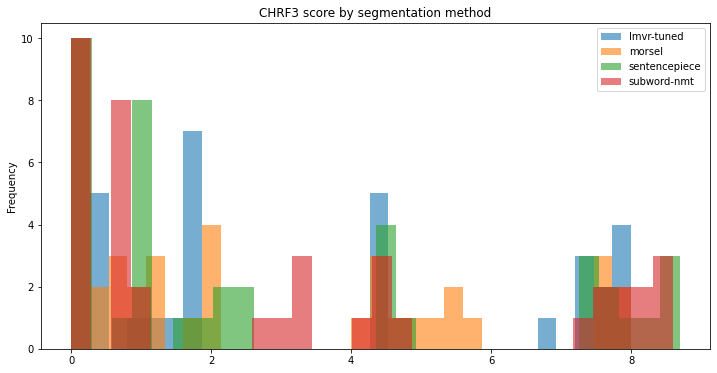

In [17]:
t = 'CHRF3 score by segmentation method'
combined_results\
    .groupby(['method'])\
    .bleu.plot(kind='hist', title=t, stacked=True,
               alpha=0.6, figsize=(12, 6),
               bins=30, legend=True)

We can include information about both the language pair and segmentation method in a scatterplot:

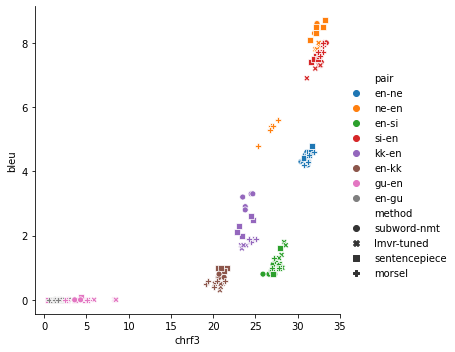

In [18]:
sns.relplot(x="chrf3", 
            y="bleu", 
            hue="pair", 
            style="method", 
            data=combined_results)

In [19]:
def posterior_predictive_check(obs, posterior_pred, metric_name='bleu'):
    criticism = pd.DataFrame()
    rand_ix = np.random.randint(low=0, high=2000)
    criticism[f'{metric_name}_fake'] = posterior_pred[f'{metric_name}_observed'][rand_ix]
    criticism[f'{metric_name}_observed'] = obs
    criticism.plot(kind='hist', alpha=0.7, title=f'Posterior predictive check: {metric_name}', figsize=(12,6), bins=30)

### Comparison against `subword-nmt`

In [20]:
def compare_to_baseline(results, baseline_method='sentencepiece'):
    """
    Creates a dictionary of seed-by-seed comparisons
    to a baseline for each language pair and model
    """
    language_pairs = set(results.pair.unique())
    segmentation_methods = set(results.method.unique())
    output = pd.DataFrame()
    for lang_pair in language_pairs:
        lang_pair_rows = results[results.pair == lang_pair].copy()
        baseline = lang_pair_rows[lang_pair_rows.method == baseline_method].set_index('seed')
        for method in segmentation_methods:
            if method == baseline_method:
                continue
            method_rows = lang_pair_rows[lang_pair_rows.method == method].set_index('seed')
            diff = method_rows[['bleu', 'chrf3']] - baseline[['bleu', 'chrf3']]
            diff['segm_method'] = method
            diff['lang_pair'] = lang_pair
            output = pd.concat([output, diff])

    return output

In [21]:
baseline_comparisons = compare_to_baseline(combined_results, baseline_method='subword-nmt')

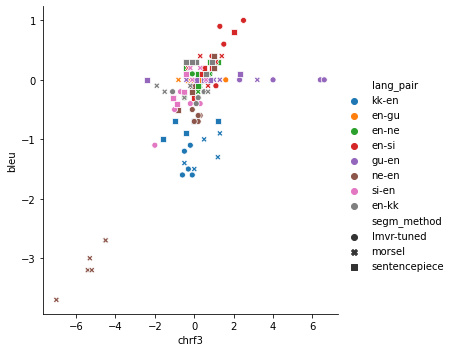

In [22]:
sns.relplot(x="chrf3", 
            y="bleu", 
            hue="lang_pair", 
            style="segm_method", 
            data=baseline_comparisons)

In [61]:
baseline_comparisons.groupby('segm_method').bleu.describe()

,count,mean,std,min,25%,50%,75%,max
segm_method,,,,,,,,
lmvr-tuned,40.0,-0.2950,0.583073,-1.6,-0.525,-0.20,0.0,1.0
morsel,40.0,-0.5425,1.103116,-3.7,-0.450,-0.05,0.0,0.4
sentencepiece,40.0,-0.0550,0.377543,-1.0,-0.225,0.00,0.2,0.8


In [23]:
baseline_comparisons.groupby('segm_method').chrf3.describe()

,count,mean,std,min,25%,50%,75%,max
segm_method,,,,,,,,
lmvr-tuned,40.0,0.7125,1.726890,-2.0,-0.125,0.20,0.95,6.6
morsel,40.0,-0.4750,2.119960,-7.0,-0.500,0.05,0.70,3.2
sentencepiece,40.0,0.1000,0.904689,-2.4,-0.400,0.10,0.65,2.3


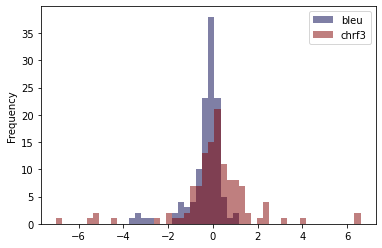

In [24]:
baseline_comparisons.plot(kind='hist', alpha=0.5, cmap='seismic', bins=50)

### Regression models for BLEU and CHRF3 

In [25]:
lang_pair_encoder = LabelEncoder()
segm_method_encoder = LabelEncoder()

In [26]:
lang_pair_data = lang_pair_encoder.fit_transform(combined_results.pair)

In [27]:
segm_method_data = segm_method_encoder.fit_transform(combined_results.method)

In [28]:
n_lang_pairs = len(lang_pair_encoder.classes_)

In [29]:
n_segm_methods = len(segm_method_encoder.classes_)

In [30]:
method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}

In [31]:
lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}

In [32]:
combined_results_sans_gu = combined_results[~combined_results.pair.str.contains('gu')].copy()

In [33]:
def fit_bleu_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          n=2000, target_accept=0.85, tune=2000):
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    bleu_observations = observed_data.bleu #+ np.random.normal(scale=1e-20, size=len(observed_data))
    
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('sentencepiece - subword-nmt', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('lmvr-tuned - subword-nmt', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('morsel - subword-nmt', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                         mu=b,
                                         sigma=eps,
                                         observed=bleu_observations)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [34]:
(bleu_model_a, 
 prior_bleu_a, 
 posterior_bleu_a, 
 posterior_pred_bleu_a) = fit_bleu_normal_model(combined_results_sans_gu, 
                                           lang_pair_encoder, 
                                           segm_method_encoder, 
                                           tune=10000, n=10000, target_accept=0.99,
                                           init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 804 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4026390a90>],
      dtype=object)

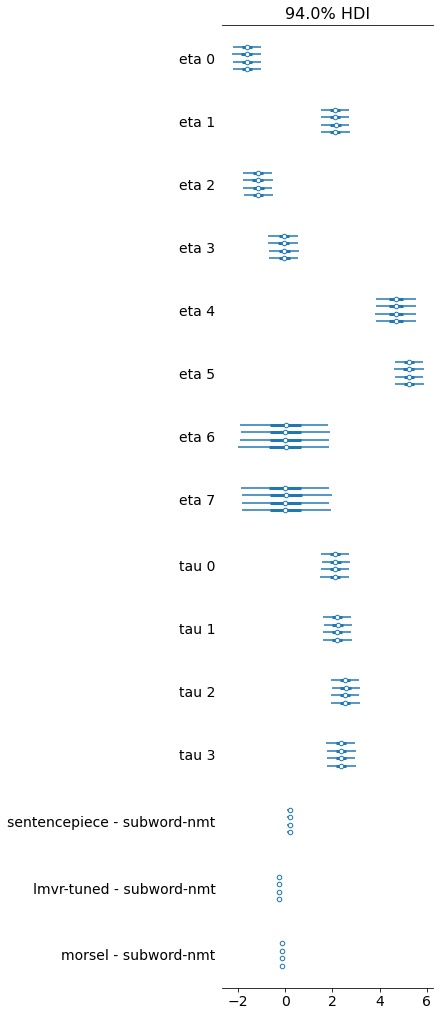

In [62]:
pm.forestplot(posterior_bleu_a, var_names='~noise')#, filter_vars='regex')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f403fcbe850>,
      dtype=object)

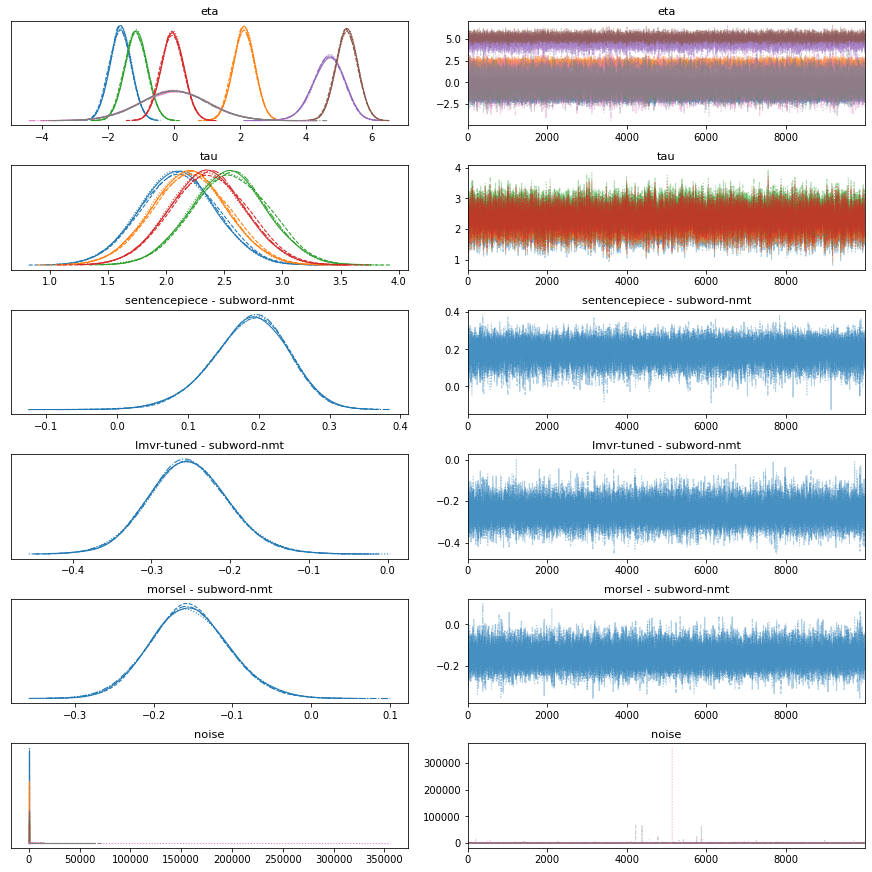

In [36]:
pm.traceplot(posterior_bleu_a)

In [37]:
def fit_chrf3_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          n=2000, target_accept=0.85, tune=2000):
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    chrf3_observations = observed_data.chrf3
    
    chrf3_model = pm.Model()
    with chrf3_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('sentencepiece - subword-nmt', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('lmvr-tuned - subword-nmt', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('morsel - subword-nmt', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        chrf3_observed = pm.Normal('chrf3_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=chrf3_observations)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return chrf3_model, prior, posterior, posterior_pred

In [38]:
(chrf3_model_a, 
 prior_chrf3_a, 
 posterior_chrf3_a, 
 posterior_pred_chrf3_a) = fit_chrf3_normal_model(combined_results, 
                                                   lang_pair_encoder, 
                                                   segm_method_encoder, tune=10000, target_accept=0.9,
                                                   init_str="adapt_diag", n=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 75 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40277d3790>],
      dtype=object)

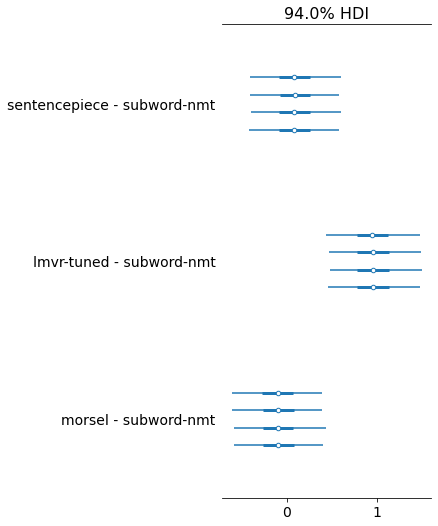

In [39]:
pm.forestplot(posterior_chrf3_a, var_names='.*subword-nmt', filter_vars='regex')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f402782bf90>,
      dtype=object)

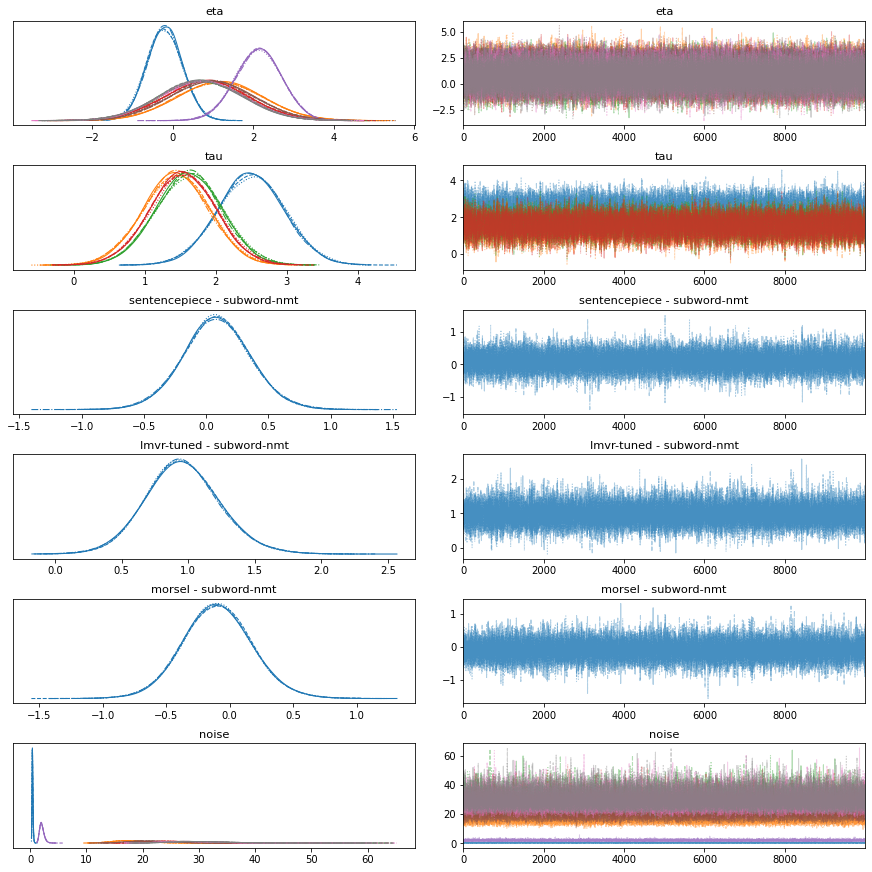

In [40]:
pm.traceplot(posterior_chrf3_a)#, model=chrf3_model_a)

### O(LM) model with a single term

We could also define $L \cdot M$ parameters, $\theta_{lm}$, representing the additive BLEU/CHRF3 effect of using segmentation method $m$ with language pair $l$ as:

$$
\text{BLEU}_{lm} = \theta_{lm} + \epsilon 
$$

Obviously the downside here is that there are a multiplicative rather than additive number of parameters earlier with model-independent $\tau$ terms and language-independent $\eta$ terms:

In [41]:
import itertools as it

In [42]:
method_lang_pair_encoder = LabelEncoder()

In [43]:
method_lang_pair_values = [f"{l}-{m}" for l, m in it.product(
                            ['en-gu','gu-en', 'en-kk', 'kk-en', 'ne-en', 'en-ne', 'si-en', 'en-si'],
                            ['lmvr-tuned', 'morsel', 'sentencepiece','subword-nmt'])]

In [44]:
method_lang_pair_encoder.fit(method_lang_pair_values)

LabelEncoder()

In [45]:
def fit_theta_model_bleu(observed_data, 
                         method_lang_pair_encoder, 
                         lang_pair_encoder, 
                         equal_variances=False,
                         init_str="jitter+adapt_diag", 
                         n=2000, target_accept=0.85, tune=2000):
    
    method_lang_pair_combos = observed_data.apply(lambda row: f"{row.pair}-{row.method}", axis=1)
    method_lang_pair_data = method_lang_pair_encoder.transform(method_lang_pair_combos)
    lang_pair_data = lang_pair_encoder.transform(observed_data.pair)
    print(f"lang pair data shape: {lang_pair_data.shape}")
    print(f"observed data shape: {observed_data.shape}")
    
    n_components = len(method_lang_pair_encoder.classes_) + 1
    n_lang_pairs = len(lang_pair_encoder.classes_) + 1
    
    bleu_model = pm.Model()
    with bleu_model:

        theta = pm.Normal('theta', mu=0, sigma=1, shape=n_components)
        b = theta[method_lang_pair_data]
        
        if equal_variances:
            eps = pm.HalfCauchy('noise', 5)
        else:
            noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
            eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                         mu=b,
                                         sigma=eps,
                                         observed=observed_data.bleu)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

### BLEU, equal variance

In [46]:
(bleu_theta_model_eqvar, 
 prior_bleu_theta_eqvar, 
 posterior_bleu_theta_eqvar, 
 posterior_pred_bleu_theta_eqvar) = fit_theta_model_bleu(combined_results_sans_gu,
                                                         method_lang_pair_encoder,
                                                         lang_pair_encoder, 
                                                         equal_variances=True,
                                                         tune=2000, target_accept=0.9,
                                                         init_str="adapt_diag", n=10000)

lang pair data shape: (120,)
observed data shape: (120, 5)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, theta]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 20 seconds.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4027753e10>,
      dtype=object)

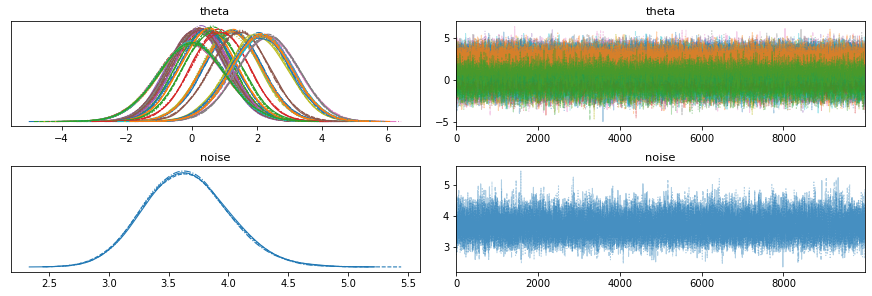

In [47]:
pm.traceplot(posterior_bleu_theta_eqvar)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4022091410>],
      dtype=object)

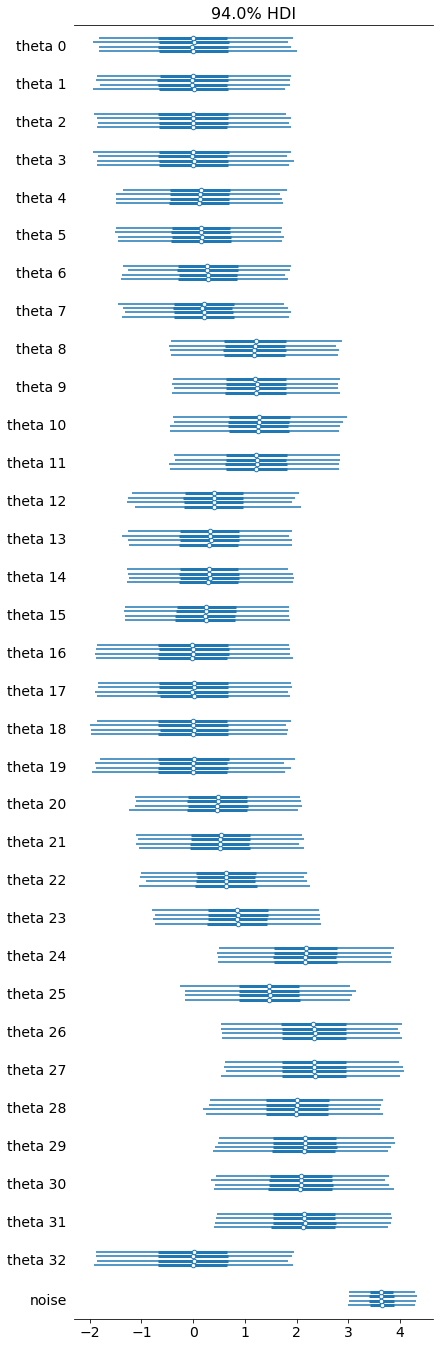

In [48]:
pm.forestplot(posterior_bleu_theta_eqvar)

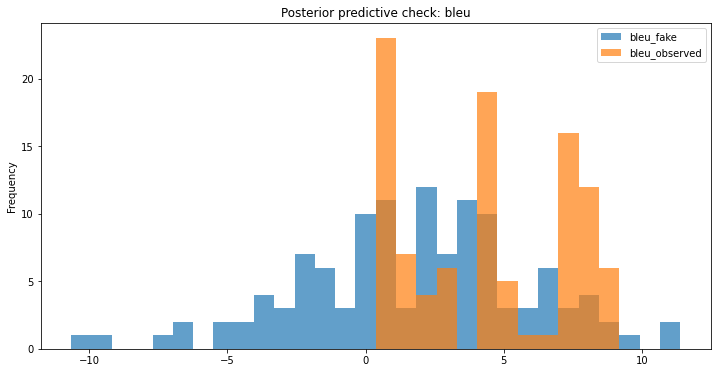

In [49]:
posterior_predictive_check(combined_results_sans_gu.bleu, posterior_pred_bleu_theta_eqvar)

### BLEU, unequal variance

In [50]:
(bleu_theta_model_uneqvar, 
 prior_bleu_theta_uneqvar, 
 posterior_bleu_theta_uneqvar, 
 posterior_pred_bleu_theta_uneqvar) = fit_theta_model_bleu(combined_results_sans_gu,
                                                         method_lang_pair_encoder,
                                                         lang_pair_encoder, 
                                                         equal_variances=False,
                                                         tune=2000, target_accept=0.9,
                                                         init_str="adapt_diag", n=10000)

lang pair data shape: (120,)
observed data shape: (120, 5)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, theta]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 28 seconds.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f401ee3f950>,
      dtype=object)

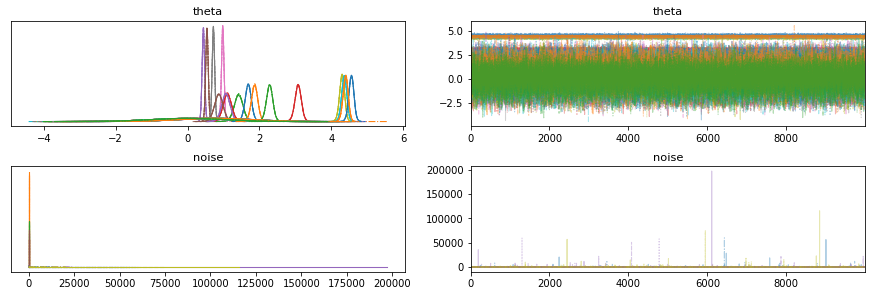

In [51]:
pm.traceplot(posterior_bleu_theta_uneqvar)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4026587a10>],
      dtype=object)

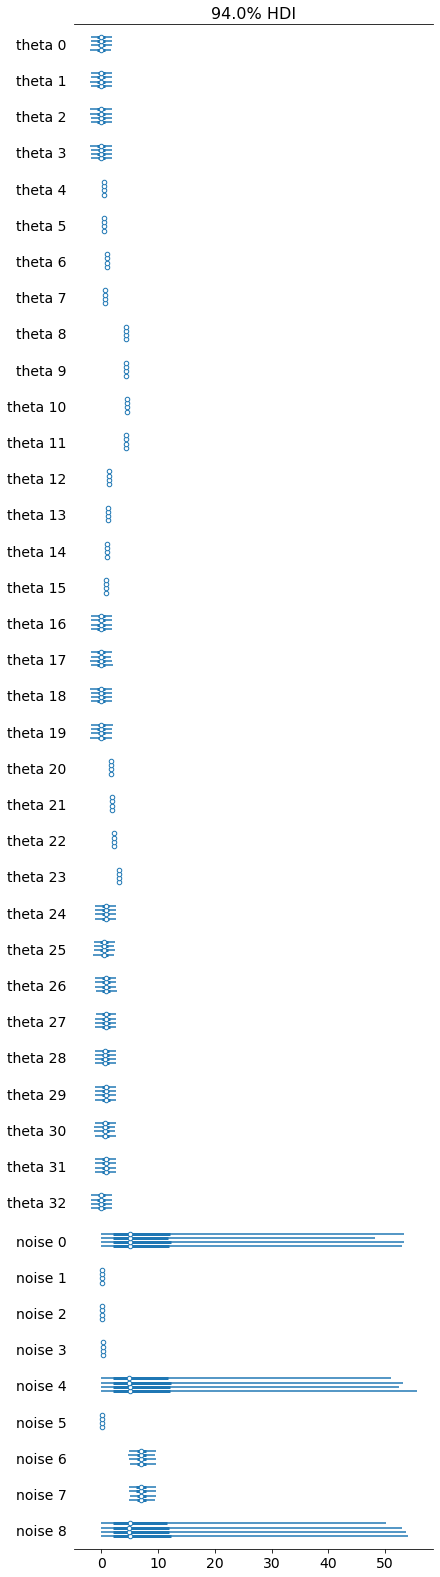

In [52]:
pm.forestplot(posterior_bleu_theta_uneqvar)

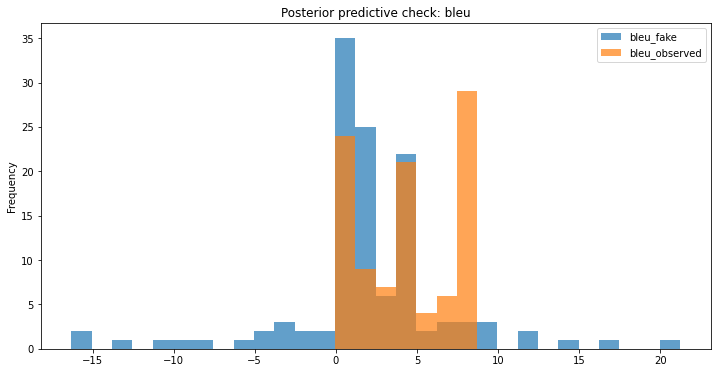

In [53]:
posterior_predictive_check(combined_results_sans_gu.bleu, posterior_pred_bleu_theta_uneqvar)

### CHRF3, equal variance

In [54]:
def fit_theta_model_chrf3(observed_data, 
                         method_lang_pair_encoder, 
                         lang_pair_encoder, 
                         equal_variances=False,
                         init_str="jitter+adapt_diag", 
                         n=2000, target_accept=0.85, tune=2000):
    
    method_lang_pair_combos = observed_data.apply(lambda row: f"{row.pair}-{row.method}", axis=1)
    method_lang_pair_data = method_lang_pair_encoder.transform(method_lang_pair_combos)
    lang_pair_data = lang_pair_encoder.transform(observed_data.pair)
    print(f"lang pair data shape: {lang_pair_data.shape}")
    print(f"observed data shape: {observed_data.shape}")
    
    n_components = len(method_lang_pair_encoder.classes_) + 1
    n_lang_pairs = len(lang_pair_encoder.classes_) + 1
    
    chrf3_model = pm.Model()
    with chrf3_model:

        theta = pm.Normal('theta', mu=0, sigma=1, shape=n_components)
        b = theta[method_lang_pair_data]
        
        if equal_variances:
            eps = pm.HalfCauchy('noise', 5)
        else:
            noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
            eps = noise[lang_pair_data]

        chrf3_observed = pm.Normal('chrf3_observed',
                                   mu=b, sigma=eps,
                                   observed=observed_data.chrf3)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return chrf3_model, prior, posterior, posterior_pred

In [55]:
(chrf3_theta_model_eqvar, 
 prior_chrf3_theta_eqvar, 
 posterior_chrf3_theta_eqvar, 
 posterior_pred_chrf3_theta_eqvar) = fit_theta_model_chrf3(combined_results,
                                                         method_lang_pair_encoder,
                                                         lang_pair_encoder, 
                                                         equal_variances=True,
                                                         tune=2000, target_accept=0.9,
                                                         init_str="adapt_diag", n=10000)

lang pair data shape: (160,)
observed data shape: (160, 5)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, theta]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 22 seconds.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4022ea9f10>,
      dtype=object)

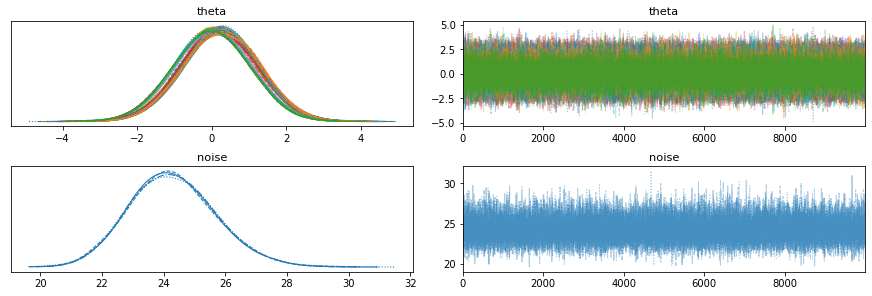

In [56]:
pm.traceplot(posterior_chrf3_theta_eqvar)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f402286ddd0>],
      dtype=object)

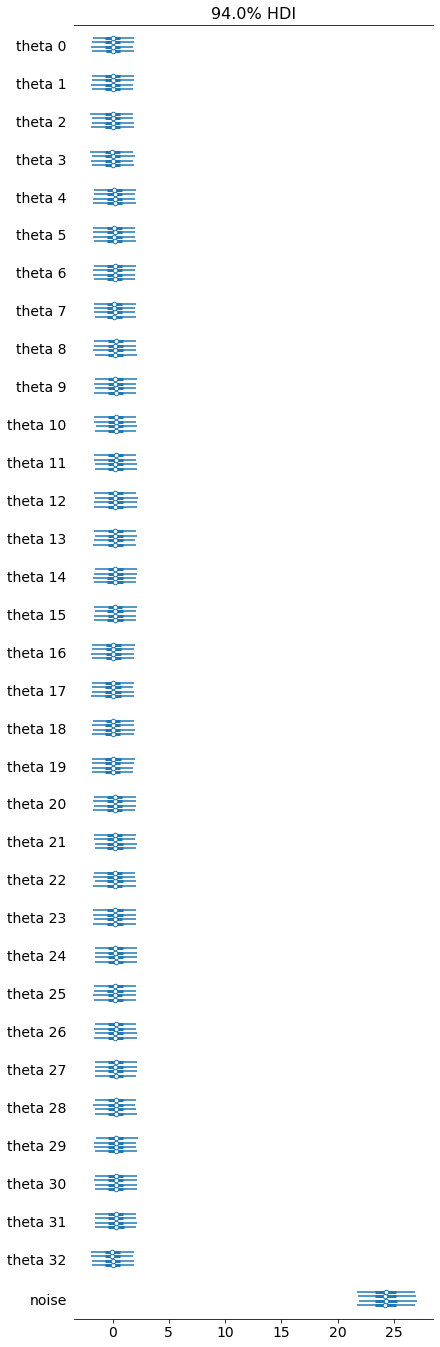

In [57]:
pm.forestplot(posterior_chrf3_theta_eqvar)

In [58]:
(chrf3_theta_model_uneqvar, 
 prior_chrf3_theta_uneqvar, 
 posterior_chrf3_theta_uneqvar, 
 posterior_pred_chrf3_theta_uneqvar) = fit_theta_model_chrf3(combined_results,
                                                         method_lang_pair_encoder,
                                                         lang_pair_encoder, 
                                                         equal_variances=False,
                                                         tune=2000, target_accept=0.9,
                                                         init_str="adapt_diag", n=10000)

lang pair data shape: (160,)
observed data shape: (160, 5)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, theta]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 25 seconds.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4022838390>,
      dtype=object)

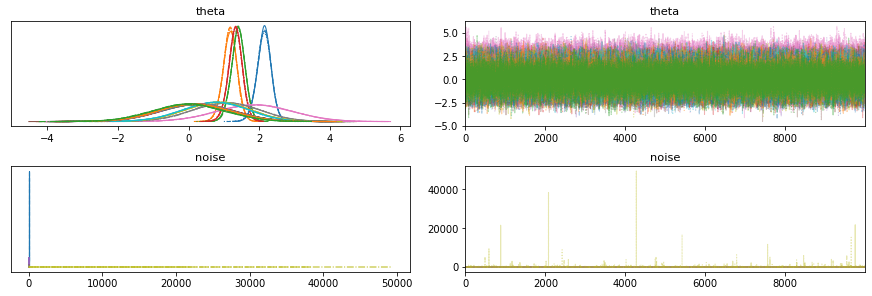

In [59]:
pm.traceplot(posterior_chrf3_theta_uneqvar)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4026869050>],
      dtype=object)

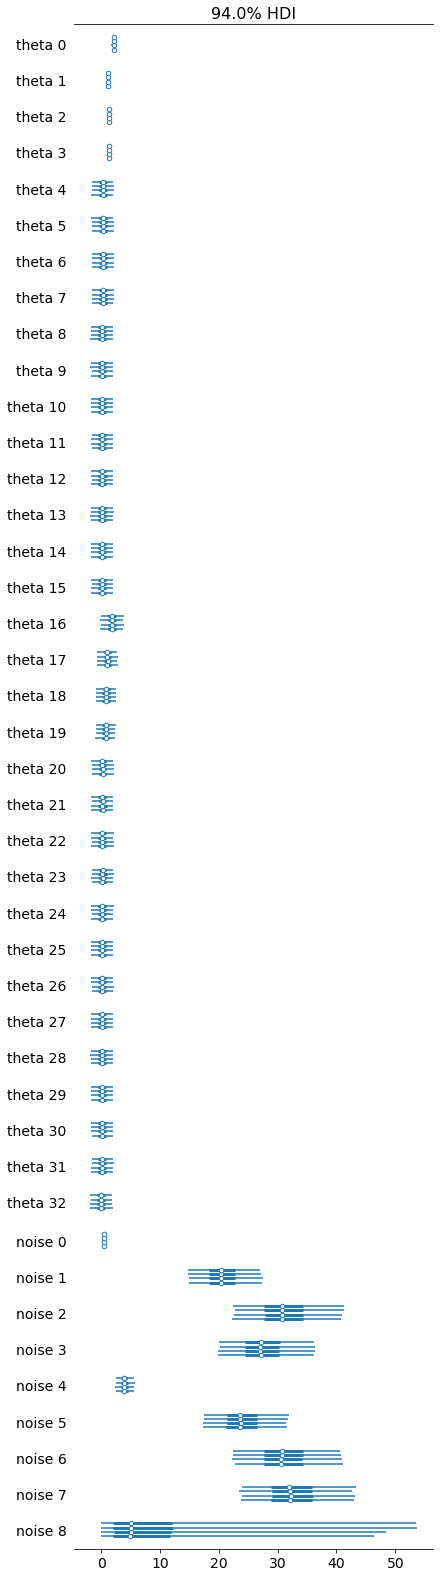

In [60]:
pm.forestplot(posterior_chrf3_theta_uneqvar)